# Analysis

This notebook contains the analysis of the cleaned dataset, the genre, and topic classes

In [1]:
import pandas as pd
import tiktoken
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import get_tokens_symbols, files_to_df_func, files_to_df_core_func
import tiktoken

from dotenv import load_dotenv, find_dotenv
load_dotenv()

directory = './data/ncse_text_chunks'

dev_transcripts = 'data/dev_data_transcript'

dev_gpt4_results = 'data/dev_data_gpt-4-turbo-preview'
dev_gpt3_results = 'data/dev_data_gpt-3.5-turbo'

save_figs = os.getenv("save_figs")


overproof_folder = 'data/overproof'
smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'article_level', 'raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')

ca_folder =  os.path.join(overproof_folder, 'CA')
ca_articles_raw = os.path.join(ca_folder, 'article_level', 'raw')
ca_articles_transcribed = os.path.join(ca_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
ca_articles_results = os.path.join(ca_folder, 'results')


transcripts_path = "data/transcription_returned_ocr/transcription_files"#dev_transcripts

model_name_code = pd.Series(
    {'Llama 2 70B':'llama2-70b-4096',
 'Gemma 7B':'gemma-7b-it',
 'Opus':'claude-3-opus-20240229',
 'Haiku':'haiku',
 'GPT-4':'gpt-4-turbo-preview',
 'GPT-3.5':'gpt-3.5-turbo',
 'Mixtral 8x7B':'mixtral-8x7b-32768'})



# Basic data set information

This section just provides basic information about the dataset for the methods section of the paper

In [2]:
periodicals_page_df = pd.read_parquet('./data/periodicals_page.parquet').rename(columns={'number':'page_number'})
periodicals_page_df = periodicals_page_df[['id', 'page_number']]

periodicals_publication_df = pd.read_parquet('./data/periodicals_publication.parquet')

periodicals_publication_df['title'] = periodicals_publication_df['title'].str.replace(r"\s\(\d{4}\-\d{4}\)", "", regex=True)

periodicals_publication_df= periodicals_publication_df.sort_values('year_from')

periodicals_publication_df['years'] = periodicals_publication_df['year_from'].astype(str) +'-'+ periodicals_publication_df['year_to'].astype(str)

periodicals_publication_df#[['title', 'years', 'issue_count', 'article_count']]

,id,abbreviation,slug,title,description,ordering,title_image,year_from,year_to,issue_count,page_count,article_count,headnotes_url,weekly,years
5,22,MRUC,mruc,Monthly Repository and Unitarian Chronicle,,1806,monthly-respository.jpg,1806,1837,487,26783,51202,/headnotes/mrp.html,False,1806-1837
0,27,NS,ns,Northern Star,,1837,northern-star.jpg,1837,1852,2201,17853,230596,/headnotes/nss.html,True,1837-1852
1,20,L,l,Leader,,1850,leader.jpg,1850,1860,1011,24456,162431,/headnotes/ldr.html,True,1850-1860
4,24,EWJ,ewj,English Woman’s Journal,,1858,english-womens-journal.jpg,1858,1864,91,5663,8061,/headnotes/ewj.html,False,1858-1864
2,19,T,t,Tomahawk,,1867,tomahawk.jpg,1867,1870,188,2125,12825,/headnotes/ttw.html,True,1867-1870
3,26,PC,pc,Publishers’ Circular,,1880,publishers-circular.jpg,1880,1890,285,20827,56739,/headnotes/tec.html,True,1880-1890


In [3]:

token_symbols_df  = get_tokens_symbols(directory)

FileNotFoundError: [Errno 2] No such file or directory: './data/ncse_text_chunks'

In [4]:
periodicals_page_df = pd.read_parquet('./data/periodicals_page.parquet').rename(columns={'number':'page_number'})
periodicals_page_df = periodicals_page_df[['id', 'page_number']]

periodicals_publication_df = pd.read_parquet('./data/periodicals_publication.parquet')

periodicals_publication_df['title'] = periodicals_publication_df['title'].str.replace(r"\s\(\d{4}\-\d{4}\)", "", regex=True)

periodicals_publication_df= periodicals_publication_df.sort_values('year_from')

periodicals_publication_df['Years'] = periodicals_publication_df['year_from'].astype(str) +'-'+ periodicals_publication_df['year_to'].astype(str)

periodicals_publication_df = periodicals_publication_df.merge(token_symbols_df.groupby('publication_id')[['total_tokens']].sum(), left_on='id', right_on = 'publication_id')

periodicals_publication_df = periodicals_publication_df[['title', 'Years', 'issue_count', 'article_count', 'total_tokens']].rename(columns = {
    'issue_count':'Issues', 'article_count':'Articles (k)', 'total_tokens':'Tokens (M)',
    'title':'Title'
})

periodicals_publication_df['Articles (k)'] = (periodicals_publication_df['Articles (k)']/1e3).round().astype(int)
periodicals_publication_df['Tokens (M)'] = (periodicals_publication_df['Tokens (M)']/1e6).round().astype(int)
#periodicals_publication_df['Tokens/Article'] = (periodicals_publication_df['Tokens (M)']*1e3  /periodicals_publication_df['Articles (k)']).round().astype(int)


periodicals_publication_df

column_format = 'p{5cm}lrrr'  # 'p{5cm}' for Title, 'l' for Impact Factor, 'r' for ISSN
latex_table = periodicals_publication_df.to_latex(index=False, caption="The periodicals in the NCSE and their key information", label="tab:periodicals_table", column_format=column_format)
print(latex_table)

NameError: name 'token_symbols_df' is not defined

## The test Dataset

In [5]:
def render_latex_with_formatting(df, caption, label):

    df = df.copy()
    # Format the 'Total' row by appending \textbf{} to each element
    df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
    
    # Convert DataFrame to LaTeX
    latex_table = df.to_latex(
        index=False,
        escape=False,  # Important to render LaTeX commands within the table properly
        column_format='p{5cm}cccc',  # One left-aligned column followed by four centered columns
        bold_rows=True,  # Bold the headers
        caption=caption,
        label=label
    )
    return latex_table


def calculate_totals(dataset, title):
    totals = {
        'title': title,
        'unique_rows': dataset['file_name'].nunique(),
        'total_words': dataset['word_count'].sum(),
        'total_tokens': dataset['tokens'].sum()
    }

    # Calculate the weighted mean of tokens
    weighted_sum = (dataset.groupby('file_name')['tokens'].sum() * dataset.groupby('file_name')['tokens'].count()).sum()
    totals['mean_tokens'] = weighted_sum / totals['unique_rows']

    totals_df = pd.DataFrame([totals], index=["Total"])

    return totals_df

In [6]:
test_dataset = files_to_df_func(transcripts_path)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
test_dataset['word_count'] = test_dataset['content'].apply(lambda x: len(str(x).split()))
test_dataset['tokens'] = test_dataset['content'].apply(lambda row: len(enc.encode(row)))
test_dataset['slug'] = test_dataset['file_name'].apply(
    lambda x: x.split('periodical_')[1].split('_')[0] if 'periodical_' in x else None
)

# Aggregating data by 'periodical_id'
test_dataset_g = test_dataset.groupby('slug').agg(
    unique_rows=pd.NamedAgg(column='file_name', aggfunc='nunique'),  # Count unique rows based on 'file_name'
    total_words=pd.NamedAgg(column='word_count', aggfunc='sum'),     # Sum of all words
    total_tokens=pd.NamedAgg(column='tokens', aggfunc='sum'),        # Sum of all tokens
    mean_tokens=pd.NamedAgg(column='tokens', aggfunc='mean')         # Mean of tokens
)

totals = {
    'title': 'Total',
    'unique_rows': test_dataset['file_name'].nunique(),
    'total_words': test_dataset['word_count'].sum(),
    'total_tokens': test_dataset['tokens'].sum()
}

# Calculate the weighted mean of tokens
weighted_sum = (test_dataset.groupby('file_name')['tokens'].sum() * test_dataset.groupby('file_name')['tokens'].count()).sum()
totals['mean_tokens'] = weighted_sum / totals['unique_rows']

# Create a DataFrame from the totals with an appropriate index
totals_df = pd.DataFrame([totals], index=["Total"])



# Display the aggregated DataFrame
test_dataset_g = periodicals_publication_df[['slug', 'title']].copy().merge(test_dataset_g.reset_index(), left_on = 'slug', right_on = 'slug').drop(columns='slug')

# Append the totals row to the grouped DataFrame
test_dataset = pd.concat([test_dataset_g, totals_df], ignore_index=True)

#del test_dataset_g

test_dataset['mean_tokens'] = test_dataset['mean_tokens'].round().astype(int)

test_dataset = test_dataset.rename(columns={
    'title':'Title',
    'unique_rows': 'Articles',
    'total_words': 'Words',
    'total_tokens': 'Tokens',
    'mean_tokens': 'Mean Tokens'

})

test_dataset


,Title,Articles,Words,Tokens,Mean Tokens
0,Monthly Repository and Unitarian Chronicle,11,2777,3549,323
1,Northern Star,15,13237,16329,1089
2,Leader,9,7946,9983,1109
3,English Woman’s Journal,8,4035,5038,630
4,Tomahawk,4,996,1362,340
5,Publishers’ Circular,7,2455,5086,727
6,Total,54,31446,41347,766


In [113]:


latex_table = render_latex_with_formatting(test_dataset, 'Summary Statistics of the dataset by periodical', 'tab:final_dataset_stats')
print(latex_table)

\begin{table}
\caption{Summary Statistics of the dataset by periodical}
\label{tab:final_dataset_stats}
\begin{tabular}{p{5cm}cccc}
\toprule
Title & Articles & Words & Tokens & Mean Tokens \\
\midrule
Monthly Repository and Unitarian Chronicle & 3 & 377 & 502 & 167 \\
Northern Star & 6 & 3774 & 4779 & 796 \\
Leader & 9 & 7946 & 9983 & 1109 \\
English Woman’s Journal & 8 & 4035 & 5038 & 630 \\
Tomahawk & 4 & 996 & 1362 & 340 \\
Publishers’ Circular & 1 & 466 & 893 & 893 \\
\textbf{Total} & \textbf{31} & \textbf{17594} & \textbf{22557} & \textbf{728} \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_177339/963944604.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '\textbf{31}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_177339/963944604.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '\textbf{17594}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_177339/963944604.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '\textbf{22557}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipyke

# Overproof

This is the table of the overproof dataset

In [42]:
smh_details_df = files_to_df_core_func(smh_articles_transcribed)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
smh_details_df['word_count'] = smh_details_df['content'].apply(lambda x: len(str(x).split()))
smh_details_df['tokens'] = smh_details_df['content'].apply(lambda row: len(enc.encode(row)))

totals = {
    'title':"Sydney Morning Herald",
    'unique_rows': smh_details_df['file_name'].nunique(),
    'total_words': smh_details_df['word_count'].sum(),
    'total_tokens': smh_details_df['tokens'].sum(),
    'mean_tokens': smh_details_df['tokens'].mean()
}

# Create a DataFrame from the totals with an appropriate index
smh_details_df= pd.DataFrame([totals], index=["Sydney Morning Herald"])

In [44]:
smh_details_df = files_to_df_core_func(smh_articles_transcribed)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
smh_details_df['word_count'] = smh_details_df['content'].apply(lambda x: len(str(x).split()))
smh_details_df['tokens'] = smh_details_df['content'].apply(lambda row: len(enc.encode(row)))


ca_details_df = files_to_df_core_func(ca_articles_transcribed)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
ca_details_df['word_count'] = ca_details_df['content'].apply(lambda x: len(str(x).split()))
ca_details_df['tokens'] = ca_details_df['content'].apply(lambda row: len(enc.encode(row)))

all_overproof  = pd.concat([smh_details_df, ca_details_df], ignore_index=True)


overproof_df = pd.concat([

    calculate_totals(smh_details_df, "Sydney Morning Herald" ),
    calculate_totals(ca_details_df, "Chronicalling America" ),
    calculate_totals(all_overproof , "Total" )
], ignore_index=True)


overproof_df ['mean_tokens'] = overproof_df ['mean_tokens'].round().astype(int)

overproof_df  = overproof_df .rename(columns={
    'title':'Title',
    'unique_rows': 'Articles',
    'total_words': 'Words',
    'total_tokens': 'Tokens',
    'mean_tokens': 'Mean Tokens'

})

overproof_df 

,Title,Articles,Words,Tokens,Mean Tokens
0,Sydney Morning Herald,159,52640,80992,509
1,Chronicalling America,46,18292,25178,547
2,Total,205,70932,106170,518


In [45]:


latex_table = render_latex_with_formatting(overproof_df, 'Summary Statistics of Overproof by dataset', 'tab:overproof_dataset_stats')
print(latex_table)

\begin{table}
\caption{Summary Statistics of Overproof by dataset}
\label{tab:overproof_dataset_stats}
\begin{tabular}{p{5cm}cccc}
\toprule
Title & Articles & Words & Tokens & Mean Tokens \\
\midrule
Sydney Morning Herald & 159 & 52640 & 80992 & 509 \\
Chronicalling America & 46 & 18292 & 25178 & 547 \\
\textbf{Total} & \textbf{205} & \textbf{70932} & \textbf{106170} & \textbf{518} \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_171306/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{205}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_171306/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{70932}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_171306/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{106170}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: 

# Comparing OCR performance with benchmarks

In [8]:
error_reduction = pd.read_csv('data/analysis/error_reduction.csv')

error_reduction = error_reduction.drop(columns = 'File Name').groupby('type').aggregate(['mean', 'median']).round(2).sort_values(('lev_dist', 'median')).reset_index()

error_reduction.sort_values(('lev_dist', 'median'))

type    WER            CER         \
                                            mean median    mean median   
0                       full__gemma-7b-it  -5.62  -2.51 -178.23 -20.73   
1                   instruct__gemma-7b-it  -5.04   1.08 -249.75 -20.41   
2            instruct__mixtral-8x7b-32768  30.89  47.79 -116.89  -6.08   
3                full__mixtral-8x7b-32768  26.93  41.79 -146.28  -4.27   
4                   full__llama2-70b-4096  -3.91  55.40 -290.94  -4.12   
5               instruct__llama2-70b-4096  37.29  45.61  -52.95   3.00   
6           full__claude-3-haiku-20240307  52.62  61.15  -24.53  28.05   
7   boros_complex__claude-3-opus-20240229  59.86  70.85  -55.37  36.00   
8                     full__gpt-3.5-turbo  54.55  70.75   26.31  39.70   
9       instruct__claude-3-haiku-20240307  58.14  69.89    8.32  47.51   
10                instruct__gpt-3.5-turbo  69.54  74.27   51.08  56.52   
11       boros_basic__gpt-4-turbo-preview  70.61  75.86   54.88  54.18   
12          instruct__gpt-4-turbo-preview  70.96  75.44   40.36  58.23   
13              full__gpt-4-turbo-preview  72.09  79.31   52.75  61.63   
14     boros_complex__gpt-4-turbo-preview  71.98  77.19   43.96  61.35   
15       instruct__claude-3-opus-20240229  57.05  77.70   23.18  61.30   
16           full__claude-3-opus-20240229  75.32  80.46   60.10  69.33   

   lev_dist         
       mean median  
0   -169.37 -19.76  
1   -237.58 -15.52  
2   -110.08  -6.95  
3   -138.44  -4.19  
4   -289.14  -2.54  
5    -65.63   2.54  
6    -20.74  25.43  
7    -49.38  33.77  
8     23.73  38.77  
9      9.39  47.09  
10    47.85  50.91  
11    52.39  54.28  
12    38.91  57.45  
13    50.50  58.64  
14    41.64  60.45  
15    22.99  61.23  
16    57.60  63.69

In [9]:

# Melt the DataFrame
melted_df = pd.melt(error_reduction, id_vars=['type'], var_name=['statistic', 'aggregate'])


melted_df['type'] = melted_df['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")
melted_df['model'] = melted_df['type'].str.split('_').str[-1]
melted_df['prompt'] = melted_df['type'].str.split('_').str[0]

# Display the melted DataFrame
melted_df = melted_df.merge(model_name_code.reset_index().rename(columns = {0:'model'}), on='model').rename(columns = {'index':'model_name'})

melted_df

,type,statistic,aggregate,value,model,prompt,model_name
0,full__gemma-7b-it,WER,mean,-5.62,gemma-7b-it,full,Gemma 7B
1,instruct__gemma-7b-it,WER,mean,-5.04,gemma-7b-it,instruct,Gemma 7B
2,full__gemma-7b-it,WER,median,-2.51,gemma-7b-it,full,Gemma 7B
3,instruct__gemma-7b-it,WER,median,1.08,gemma-7b-it,instruct,Gemma 7B
4,full__gemma-7b-it,CER,mean,-178.23,gemma-7b-it,full,Gemma 7B
...,...,...,...,...,...,...,...
97,boros_complex__gpt-4-turbo-preview,lev_dist,mean,41.64,gpt-4-turbo-preview,boros,GPT-4
98,boros_basic__gpt-4-turbo-preview,lev_dist,median,54.28,gpt-4-turbo-preview,boros,GPT-4
99,instruct__gpt-4-turbo-preview,lev_dist,median,57.45,gpt-4-turbo-preview,instruct,GPT-4
100,full__gpt-4-turbo-preview,lev_dist,median,58.64,gpt-4-turbo-preview,full,GPT-4


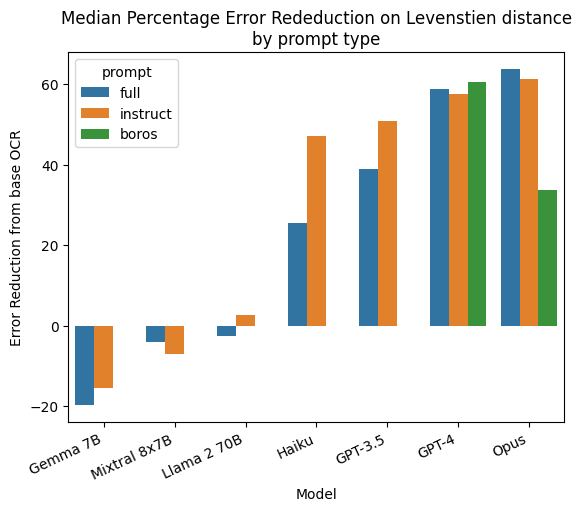

In [10]:
plot_df = melted_df.loc[(melted_df['statistic']=='lev_dist') & 
                        (melted_df['prompt']!='claude') & 
                        (melted_df['type']!='boros_basic__gpt-4-turbo-preview') &
                        (melted_df['aggregate']=='median')]

temp = plot_df[plot_df['prompt']=='full'].copy()

temp['rank'] = temp['value'].rank()

plot_df = plot_df.merge(temp[['model_name', 'rank']], on = 'model_name').sort_values('rank')

sns.barplot(data = plot_df, x = 'model_name', y = 'value', hue = 'prompt')
plt.xticks(rotation = 25, ha = 'right')
plt.title('Median Percentage Error Rededuction on Levenstien distance\nby prompt type')
plt.xlabel("Model")
plt.ylabel("Error Reduction from base OCR")

plt.savefig(os.path.join(save_figs,"error_reduction.pdf"))
plt.show()

In [124]:
benchmarks  = pd.read_csv('data/benchmarks.csv', index_col = 'benchmark').T

benchmarks['model_id'] = model_name_code

benchmarks = benchmarks.reset_index().merge(plot_df.loc[plot_df['prompt']=='full', ['value', 'model']], 
                               left_on = 'model_id', right_on = 'model').drop(['model', 'model_id'], axis = 1).rename(columns={'index':'model_name',
                                                                                                                 'value':'CLOCR'})

benchmarks.sort_values('CLOCR')

,model_name,MMLU,HellaSwag,ARC-C,WinoGrande,MBPP,DROP,CLOCR
1,Gemma 7B,64.6,82.2,61.9,79.0,44.4,NaN,-53.34
6,Mixtral 8x7B,70.6,86.7,85.8,81.2,60.7,NaN,-33.88
3,Haiku,75.2,85.9,89.2,74.2,80.4,78.9,-2.99
0,Llama 2 70B,69.9,87.1,85.1,83.2,49.8,NaN,14.65
5,GPT-3.5,70.0,85.5,85.2,81.6,52.2,64.1,39.18
4,GPT-4,86.4,93.3,96.3,87.5,NaN,80.9,61.85
2,Opus,86.8,95.4,96.6,88.5,86.4,83.1,75.89


<Axes: xlabel='DROP', ylabel='ARC-C'>

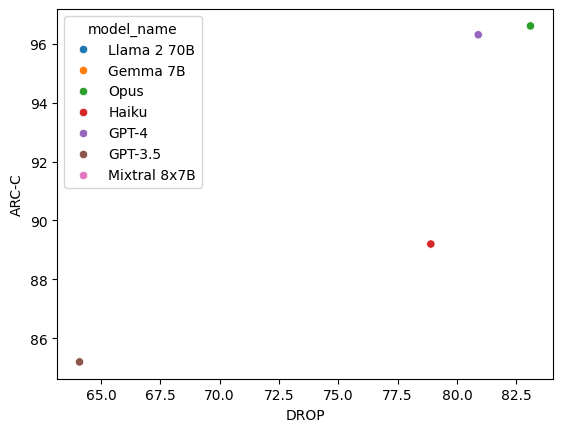

In [125]:
sns.scatterplot(data = benchmarks, x = 'DROP', y = 'ARC-C', hue = 'model_name')

In [91]:
benchmark_names = [ 'MMLU', 'HellaSwag', 'ARC-C', 'WinoGrande', 'MBPP', 'DROP', 'CLOCR']

benchmarks_norm = benchmarks.copy()

for bench_type in benchmark_names:
    benchmarks_norm[bench_type] = (benchmarks_norm[bench_type] - benchmarks_norm[bench_type].min())/(benchmarks_norm[bench_type].max() - benchmarks_norm[bench_type].min())

,MMLU,HellaSwag,ARC-C,WinoGrande,MBPP,CLOCR
MMLU,1.000000,0.956889,0.835009,0.663730,0.906160,0.838664
HellaSwag,0.956889,1.000000,0.830426,0.818435,0.743803,0.841605
ARC-C,0.835009,0.830426,1.000000,0.504622,0.759664,0.883393
WinoGrande,0.663730,0.818435,0.504622,1.000000,0.146311,0.658969
MBPP,0.906160,0.743803,0.759664,0.146311,1.000000,0.604162
CLOCR,0.838664,0.841605,0.883393,0.658969,0.604162,1.000000


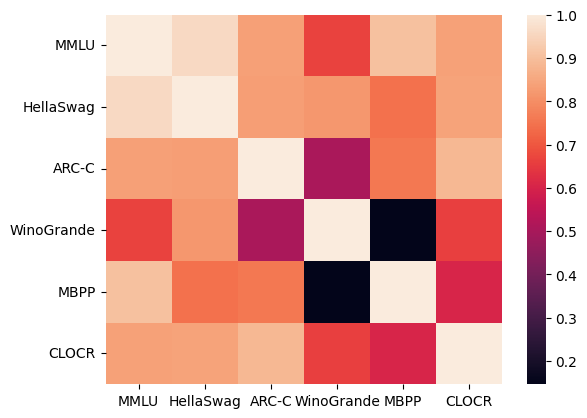

In [97]:
sns.heatmap(data = benchmarks_norm.drop(['DROP'], axis = 1).set_index('model_name').corr())

benchmarks_norm.drop([ 'DROP'], axis = 1).set_index('model_name').corr()

Text(0, 0.5, 'Cross model corellation')

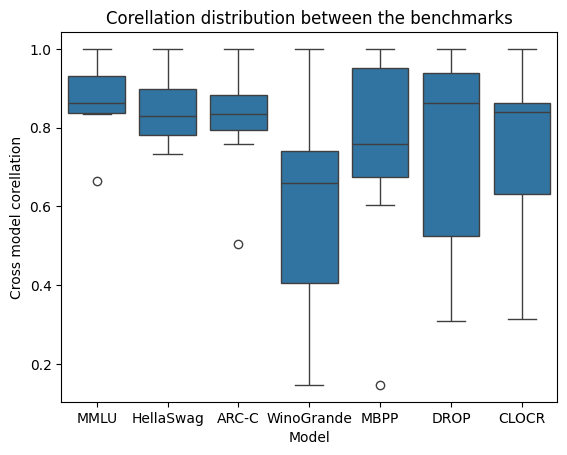

In [126]:
test = benchmarks_norm.set_index('model_name').corr(method = 'pearson').reset_index().melt(id_vars='index')

sns.boxplot(data = test, x = 'variable', y ='value')
plt.title('Corellation distribution between the benchmarks')
plt.xlabel("Model")
plt.ylabel("Cross model corellation")

       joke context  correct
0   chicken      no        0
1   chicken     yes      100
2  combined      no      100
3  combined     yes      100
4       dog      no       60
5       dog     yes       98


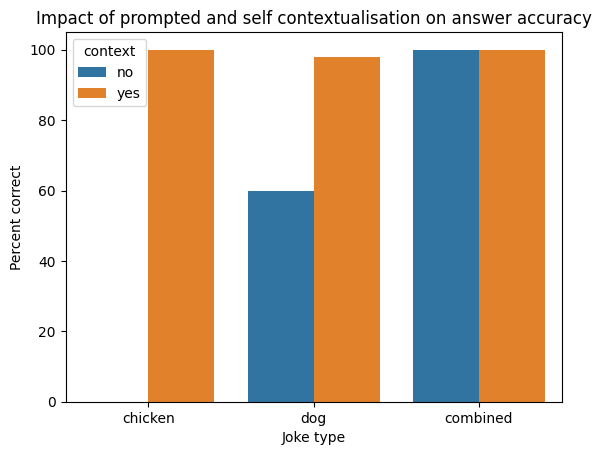

In [30]:
context_results = pd.read_csv("does_LM_use_context_results.csv")

#context_results['joke'] = context_results['joke'].replace('dog', 'Dog has no nose')
#context_results['joke'] = context_results['joke'].replace('chicken', 'Chicken cross the road?')

context_results['correct'] = context_results['correct'].astype(int)

print(context_results.groupby(['joke','context'])['correct'].sum().reset_index())

sns.barplot(data = context_results.groupby(['joke','context'])['correct'].sum().reset_index(),
            x = 'joke', y = 'correct', hue = 'context', order=["chicken", "dog", "combined"])
plt.title('Impact of prompted and self contextualisation on answer accuracy')
#plt.xticks(rotation = 25, ha = 'right')
plt.xlabel('Joke type')
plt.ylabel('Percent correct')
plt.savefig(os.path.join(save_figs,"socio_cultural.pdf"))
plt.show()

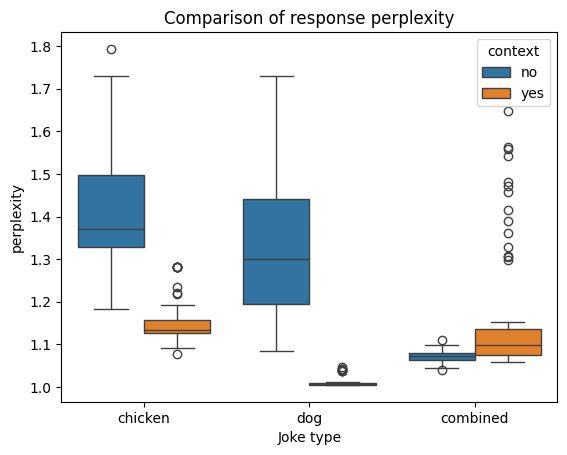

In [26]:
sns.boxplot(data = context_results,
            x = 'joke', y = 'perplexity', hue = 'context', order=["chicken", "dog", "combined"])
plt.title('Comparison of response perplexity')
plt.xlabel('Joke type')
plt.savefig(os.path.join(save_figs,"socio_cultural_perplex.pdf"))
plt.show()